# Initialization

### Loading dependencies

In [1]:
import os
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

tfk = tf.keras
tfkl = tf.keras.layers

print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Plants dataset

In [4]:
dataset_dir = './datasetNOTEST'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [5]:
# Plot example images from dataset
labels = [
          'Species1',   # 0
          'Species2',   # 1
          'Species3',   # 2
          'Species4',   # 3
          'Species5',   # 4
          'Species6',   # 5
          'Species7',   # 6
          'Species8',   # 7
          ]

## Models metadata

In [6]:
# Input Parameters
img_w = 96
img_h = 96
input_shape = (96, 96, 3)
classes = 8

# Training Parameters
epochs = 200
batch_size = 32

# Earlystopping Parameters
early_stopping = True
patience_epochs = 10

#Augmentation
apply_augmentation = True

# Data Augmentation

In [7]:
from PIL import Image, ImageEnhance


def adjust_brightness(im, factor):
    im = tf.keras.utils.array_to_img(im)
    #image brightness enhancer
    enhancer = ImageEnhance.Brightness(im)
    
     #brightens the image
    im_output = enhancer.enhance(factor)
    im_output = tf.keras.utils.img_to_array(im_output)
    return im_output

In [8]:
def preprocessing(image_gen):
    images_saturated = tf.image.adjust_saturation(image_gen,2.3)
    images_contrast_saturated = tf.image.adjust_contrast(images_saturated, 1)
    image_contrast_saturated_brightness = adjust_brightness(images_contrast_saturated, 1.3)
    
    return image_contrast_saturated_brightness


In [9]:
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocessing)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocessing)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(img_w,img_h),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)
"""test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(img_w,img_h),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             shuffle=False,
                                             seed=seed)"""

Found 713 images belonging to 8 classes.


"test_gen = test_data_gen.flow_from_directory(directory=test_dir,\n                                             target_size=(img_w,img_h),\n                                             color_mode='rgb',\n                                             classes=None, # can be set to labels\n                                             class_mode='categorical',\n                                             batch_size=batch_size,\n                                             shuffle=False,\n                                             seed=seed)"

In [10]:
# Create an instance of ImageDataGenerator with Data Augmentation
if apply_augmentation:
    train_data_gen = ImageDataGenerator(
                                        width_shift_range=38,
                                        height_shift_range=38,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        brightness_range=[0.7, 1.3],
                                        fill_mode='nearest',
                                        preprocessing_function=preprocessing)
else: 
    train_data_gen = ImageDataGenerator(preprocessing_function=preprocessing)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                target_size=(img_w,img_h),
                                                color_mode='rgb',
                                                classes=None, # can be set to labels
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

Found 2829 images belonging to 8 classes.


In [11]:
from  sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_gen.classes), 
            y=train_gen.classes)
# Keras requires a dictionary
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

# Transfer Learning

In [14]:
# Download and plot the VGG16 model
supernet = tfk.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

# supernet.summary()

In [15]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=input_shape)

# Supernet exctrction level
x = supernet(inputs)
x = tfkl.GlobalAveragePooling2D(name='GAP')(x)

#1st Hidden layer
x = tfkl.Dense(
    256,
    kernel_initializer = tfk.initializers.he_uniform(seed))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.ReLU()(x)
x = tfkl.Dropout(0.2, seed=seed)(x)

# Output layer
outputs = tfkl.Dense(
    classes,
    activation='softmax',
    kernel_initializer = tfk.initializers.he_uniform(seed))(x)


# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 GAP (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256)               0     

In [16]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
   if epoch < 60:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

In [17]:
# Utility function to create folders and callbacks for training
from tensorflow.keras.callbacks import ModelCheckpoint

def create_callbacks() :
    callbacks = []

    # Early Stopping -----------------------------------------------------
    if early_stopping:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=30, restore_best_weights=True)
        callbacks.append(es_callback)
    
    # Checkpointer
    checkpointer = ModelCheckpoint(filepath='./checkpoint/efficientnetB0.h5', verbose=1, 
                                    save_best_only=True, monitor = "val_accuracy", mode = "auto",)
    callbacks.append(checkpointer)
    
    # Learning Rate Scheduler --------------------------------------------
    LRS_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks.append(LRS_callback)
    
    return callbacks

In [18]:
callbacks = create_callbacks()

In [19]:
# Check Transfer Learning accuracy in 10 epochs with learning rate 1e-3

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = 100,
    validation_data = valid_gen,
    class_weight = class_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=patience_epochs, restore_best_weights=True)]
).history

Epoch 1/100
89/89 [==============================] - 19s 126ms/step - loss: 1.7395 - accuracy: 0.3722 - val_loss: 1.4014 - val_accuracy: 0.5007
Epoch 2/100
89/89 [==============================] - 10s 117ms/step - loss: 1.4529 - accuracy: 0.4645 - val_loss: 1.3956 - val_accuracy: 0.4923
Epoch 3/100
89/89 [==============================] - 11s 124ms/step - loss: 1.3850 - accuracy: 0.5041 - val_loss: 1.2792 - val_accuracy: 0.5610
Epoch 4/100
89/89 [==============================] - 11s 119ms/step - loss: 1.3280 - accuracy: 0.5270 - val_loss: 1.2423 - val_accuracy: 0.5442
Epoch 5/100
89/89 [==============================] - 11s 127ms/step - loss: 1.2667 - accuracy: 0.5373 - val_loss: 1.1921 - val_accuracy: 0.5624
Epoch 6/100
89/89 [==============================] - 11s 126ms/step - loss: 1.2617 - accuracy: 0.5429 - val_loss: 1.0826 - val_accuracy: 0.6227
Epoch 7/100
89/89 [==============================] - 11s 125ms/step - loss: 1.2202 - accuracy: 0.5536 - val_loss: 1.1757 - val_accuracy:

In [20]:
# Evaluate on test set

test_metrics = model.evaluate(valid_gen, return_dict=True)
print("Test metrics without fine tuning")
print(test_metrics)

23/23 [==============================] - 1s 49ms/step - loss: 0.8965 - accuracy: 0.6872
Test metrics without fine tuning
{'loss': 0.8964948058128357, 'accuracy': 0.687237024307251}


In [21]:
model.get_layer('efficientnetb0').trainable = True

# Freeze the first 120 layers
for i, layer in enumerate(model.get_layer('efficientnetb0').layers[:120]):
  layer.trainable=False

print()

#for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
#   print(i, layer.name, layer.trainable)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 3, 3, 1280)       4049571   
                                                                 
 GAP (GlobalAveragePooling2D  (None, 1280)             0         
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256)               0    

In [22]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

# Train the model
history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = 200,
    validation_data = valid_gen,
    class_weight = class_weights,
    callbacks = callbacks
).history

Epoch 1/200
89/89 [==============================] - ETA: 0s - loss: 1.7857 - accuracy: 0.3991
Epoch 1: val_accuracy improved from -inf to 0.61290, saving model to ./checkpoint\efficientnetB0.h5
89/89 [==============================] - 18s 135ms/step - loss: 1.7857 - accuracy: 0.3991 - val_loss: 1.1050 - val_accuracy: 0.6129 - lr: 1.0000e-04
Epoch 2/200
89/89 [==============================] - ETA: 0s - loss: 1.3144 - accuracy: 0.5444
Epoch 2: val_accuracy improved from 0.61290 to 0.65077, saving model to ./checkpoint\efficientnetB0.h5
89/89 [==============================] - 11s 127ms/step - loss: 1.3144 - accuracy: 0.5444 - val_loss: 1.0584 - val_accuracy: 0.6508 - lr: 1.0000e-04
Epoch 3/200
89/89 [==============================] - ETA: 0s - loss: 1.1395 - accuracy: 0.5910
Epoch 3: val_accuracy improved from 0.65077 to 0.66480, saving model to ./checkpoint\efficientnetB0.h5
89/89 [==============================] - 11s 126ms/step - loss: 1.1395 - accuracy: 0.5910 - val_loss: 1.0196 - 

In [23]:
# Print Confusion Matrix and Classification Report (Precision, Recall, and F1-score) on the validation set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Y_prediction = model.predict_generator(valid_gen, len(valid_gen))
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = valid_gen.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
class_report = classification_report(Y_true, Y_pred_classes, 
                                     target_names=valid_gen.class_indices.keys())  # target_names must be ordered depending on the class labels
print('Confusion Matrix:')
print(confusion_mtx)
print()
print('Classification Report:')
print(class_report)

Confusion Matrix:
[[ 18   4   0   7   0   1   0   8]
 [  1  95   0   3   0   1   7   0]
 [  0   1  94   3   5   0   0   0]
 [  1   1   2  90   7   1   0   1]
 [  1   0   2   2 101   0   0   1]
 [  0   4   0   0   0  38   2   1]
 [  0   1   0   0   0   0 104   3]
 [  7   5   1   3   3   0   4  79]]

Classification Report:
              precision    recall  f1-score   support

    Species1       0.64      0.47      0.55        38
    Species2       0.86      0.89      0.87       107
    Species3       0.95      0.91      0.93       103
    Species4       0.83      0.87      0.85       103
    Species5       0.87      0.94      0.91       107
    Species6       0.93      0.84      0.88        45
    Species7       0.89      0.96      0.92       108
    Species8       0.85      0.77      0.81       102

    accuracy                           0.87       713
   macro avg       0.85      0.83      0.84       713
weighted avg       0.87      0.87      0.87       713



In [1]:
# Predict basic_model
print("Basic model: ")
model_test_metrics = model.evaluate(valid_gen, return_dict=True)

Basic model: 


NameError: name 'model' is not defined

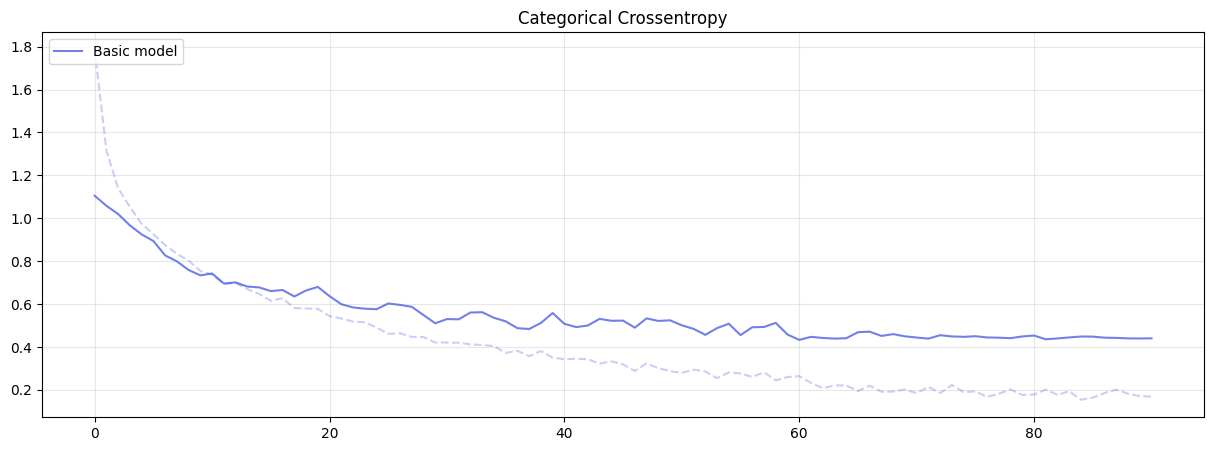

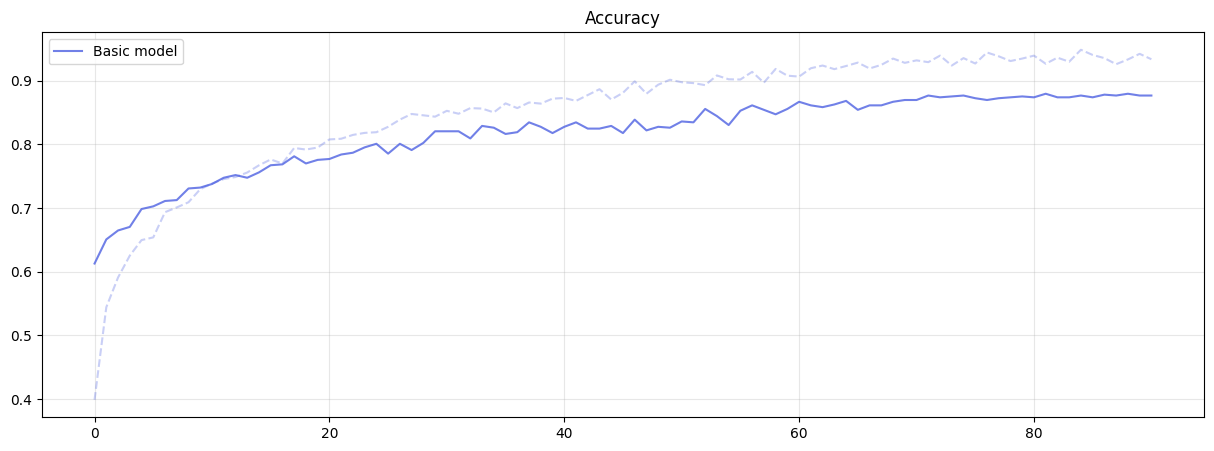

In [25]:
# Plot loss
plt.figure(figsize=(15,5))

plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Basic model', alpha=.8, color='#4D61E2')

plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)


# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Basic model', alpha=.8, color='#4D61E2')


plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()